## Import main packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

## Adjustments (knobs/parameters) - added for more flexibility

In [ ]:
# [0:"kNN", 1:"DT", 2:"AdaBoost", 3:"GNB", 4:"LR", 5:"LDA", 6:"SVM.SVC", 7:"LogitBoost"]
mls_to_test = [0, 2, 3, 4, 5, 6, 7]

# training iteration multiplier
tim = 1

# seed for training (author used "0" or zero)
seed = None

## Import Specific Modules

In [2]:
# preprocessing
from sklearn.preprocessing import normalize

# classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from logitboost import LogitBoost

from tqdm import tqdm
# model selection
from sklearn.model_selection import StratifiedShuffleSplit

# model evaluation
from sklearn.metrics import confusion_matrix, auc

## Define classifiers, and corresponding parameters

In [3]:
classifierNames = pd.DataFrame(["kNN", "DT", "AdaBoost","GNB","LR", "LDA","SVM.SVC","LogitBoost"])

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'),
    LinearDiscriminantAnalysis(),  # rv.kris - this is the default of the author
    # LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.81),  # rv.kris - this is our study but it gives a horrible outcome
    make_pipeline(StandardScaler(), SVC(gamma='auto')),
    LogitBoost(n_estimators=200, random_state=0)
]

## Define settings for printing, plotting, etc.

In [4]:
pd.set_option("display.float_format", lambda x: "%.3f" % x)
%matplotlib inline

## Read input data from file
Data contains 3 columns: 'date', 'rain1'(1-day cumulative rainfall), and 'ls' (boolean to indicate if date is a landslide or non-landslide event). Rainfall data, from 2014 to 2018 is from PAGASA Baguio synoptic station, whereas landslide or non-landslide event is determined from the maintenance records of the DPWH.

In [5]:
# read from csv file, get 'date', 'rain', and 'landslide' columns
rainls = pd.read_csv("DATAhumidity.csv", usecols=list(range(0, 12)))

# format date column
rainls["date"] = pd.to_datetime(rainls["date"])

# show first five rows of dataframe
print(rainls.head(10))

# show dimensions of the dataframe (rows, columns)
rainls.shape

        date  rain1  totmaxh  meanmaxh  totminh  meanminh   aveh  highh  \
0 2015-01-01  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
1 2015-01-02  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
2 2015-01-03  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
3 2015-01-04  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
4 2015-01-05  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
5 2015-01-06  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
6 2015-01-07  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
7 2015-01-08  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
8 2015-01-09  0.000  675.500    21.790  376.600    12.148 16.969 24.600   
9 2015-01-10  0.000  675.500    21.790  376.600    12.148 16.969 24.600   

    lowh  meanh  relhumh  den  
0 10.400 17.500       84    0  
1 10.400 17.500       84    0  
2 10.400 17.500       84    0  
3 10.400 17.500       84    0  
4 10.400 17.50

(1461, 12)

## Create features

With the hypothesis that the landslide occurrences are determined by certain rainfall characteristics, we create features (columns) from the rainfall time series in our input data.  We explore combinations of cumulative and offset functions to generate the various rainfall characteristics.

In [6]:
# FINAL FEATURE GENERATION
shift = list(range(0, 175))     #(25 weeks) #(Carvajal, T.M., Viacrusis, K.M., Hernandez, L.F.T. et al. Machine learning methods reveal the temporal pattern of dengue incidence using meteorological factors in metropolitan Manila, Philippines. BMC Infect Dis 18, 183 (2018). https://doi.org/10.1186/s12879-018-3066-0)
shiftrain = pd.DataFrame(index=rainls.index)
for i in shift:
    shiftrain[f"shift_{str(i)}"] = rainls["rain1"].shift(-i)
    shiftrain[f"shiftmmaxh_{str(i)}"] = rainls["meanmaxh"].shift(-i)
    shiftrain[f"shiftmminh_{str(i)}"] = rainls["meanminh"].shift(-i)
    shiftrain[f"shiftmeanh_{str(i)}"] = rainls["meanh"].shift(-i)
    shiftrain[f"shiftrh_{str(i)}"] = rainls["relhumh"].shift(-i)
# adding lables to samples (rows)
shiftrain["den"] = rainls.den
# removing NaNs as result of cumulative and lag functions
shiftrain = shiftrain.dropna(axis=0, how="any")
COrain = shiftrain
COrain

C:\Users\MIS\AppData\Local\Temp\ipykernel_12828\1802251456.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shiftrain[f"shift_{str(i)}"] = rainls["rain1"].shift(-i)
C:\Users\MIS\AppData\Local\Temp\ipykernel_12828\1802251456.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shiftrain[f"shiftmmaxh_{str(i)}"] = rainls["meanmaxh"].shift(-i)
C:\Users\MIS\AppData\Local\Temp\ipykernel_12828\1802251456.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

,shift_0,shiftmmaxh_0,shiftmminh_0,shiftmeanh_0,shiftrh_0,shift_1,shiftmmaxh_1,shiftmminh_1,shiftmeanh_1,shiftrh_1,...,shiftmmaxh_173,shiftmminh_173,shiftmeanh_173,shiftrh_173,shift_174,shiftmmaxh_174,shiftmminh_174,shiftmeanh_174,shiftrh_174,den
0,0.000,21.790,12.148,17.500,84,0.000,21.790,12.148,17.500,84.000,...,24.600,16.900,21.200,89.000,1.000,24.600,16.900,21.200,89.000,0
1,0.000,21.790,12.148,17.500,84,0.000,21.790,12.148,17.500,84.000,...,24.600,16.900,21.200,89.000,0.000,24.600,16.900,21.200,89.000,0
2,0.000,21.790,12.148,17.500,84,0.000,21.790,12.148,17.500,84.000,...,24.600,16.900,21.200,89.000,1.600,24.600,16.900,21.200,89.000,0
3,0.000,21.790,12.148,17.500,84,0.000,21.790,12.148,17.500,84.000,...,24.600,16.900,21.200,89.000,0.200,24.600,16.900,21.200,89.000,0
4,0.000,21.790,12.148,17.500,84,0.000,21.790,12.148,17.500,84.000,...,24.600,16.900,21.200,89.000,3.000,24.600,16.900,21.200,89.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,0.000,22.100,16.300,19.500,94,10.800,22.100,16.300,19.500,94.000,...,23.800,14.100,19.800,81.000,0.000,23.800,14.100,19.800,81.000,0
1283,10.800,22.100,16.300,19.500,94,32.600,22.100,16.300,19.500,94.000,...,23.800,14.100,19.800,81.000,8.400,23.800,14.100,19.800,81.000,0
1284,32.600,22.100,16.300,19.500,94,8.400,22.100,16.300,19.500,94.000,...,23.800,14.100,19.800,81.000,5.600,23.800,14.100,19.800,81.000,0
1285,8.400,22.100,16.300,19.500,94,38.800,22.100,16.300,19.500,94.000,...,23.800,14.100,19.800,81.000,1.000,23.800,14.100,19.800,81.000,0


## Splitting, training, testing, evaluating

# MEAN MAX MINIMUM TEMPERATURE RELATIVE HUMIDITY

In [7]:
my_list = list(range(tim))        # rv.kris - this increases the number of iterations, the author set this to 100, but this also multiples the training time by the same amount

# define split function
n_splits = 30
test_size = 0.25
random_state = seed
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

# create dataframes for evaluation results
TPRs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])
FPRs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])
TNRs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])
aROCs = pd.DataFrame(index=range(n_splits), columns=classifierNames[0])

# loop through all splits
with tqdm(total=len(my_list)) as pbar:
    for x in my_list:
        for s, (train_index, test_index) in zip(TPRs.index, sss.split(COrain.iloc[:, :-1], COrain.iloc[:, -1])):
            # define training and testing sets using results of the splitting function
            ytrain, ytest = COrain["den"].iloc[train_index], COrain["den"].iloc[test_index]
            Xtrain, Xtest = COrain[COrain.columns[:-1]].iloc[train_index], COrain[COrain.columns[:-1]].iloc[test_index]
            # normalize training set features (column-wise)
            Xtrain_norm, Xnorm = normalize(Xtrain, axis=0, return_norm=True)
            # normalize testing set features (column-wise)
            Xtest_norm = Xtest/Xnorm
            # loop through algorithms
            for c in range(len(classifierNames)):
                if c not in mls_to_test:continue      # skip some algorithms # rv.kris
                
                # define current classifier
                clf = classifiers[c]
                # train the classifier using the training set
                clf.fit(Xtrain_norm, ytrain)
                # predict values using the trained classifier and the test set
                Xtest_norm = np.array(Xtest_norm)         # rv.kris
                y_pred = clf.predict(Xtest_norm)
                
                # Evaluate the test
                # Define true values
                y_true = ytest
                # Produce confusion matrix from true and predicted values
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
                # Compute true positive and false positive rates and assign to dataframe
                tpr = np.round((tp / (tp+fn*1.)), 4)
                fpr = np.round((fp / (fp+tn*1.)), 4)
                tnr = np.round((tn / (tn+fp*1.)), 4)
                err = np.round((fp+fn / (tn+fp+tp+fn*1.)), 4)
                aROC = auc([0, fpr, 1], [0, tpr, 1])
                # Assign results to dataframes
                TPRs.loc[s, classifierNames.values[c][0]] = tpr
                TNRs.loc[s, classifierNames.values[c][0]] = tnr
                FPRs.loc[s, classifierNames.values[c][0]] = fpr
                # ERRs.loc[s, classifierNames.values[c][0]] = err
                aROCs.loc[s, classifierNames.values[c][0]] = aROC
            pbar.update(1)

# Remove NA columns (skipped algorithms)
FPRs = FPRs.dropna(axis=1, how="all")
TPRs = TPRs.dropna(axis=1, how="all")
TNRs = TNRs.dropna(axis=1, how="all")
# ERRs = ERRs.dropna(axis=1, how="all")
aROCs = aROCs.dropna(axis=1, how="all")

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 1/1 [00:10<00:00, 10.18s/it]c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)
2it [00:20, 10.08s/it]                       c:\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarnin

## Results

100%|██████████| 1/1 [00:00<00:00, 333.36it/s]


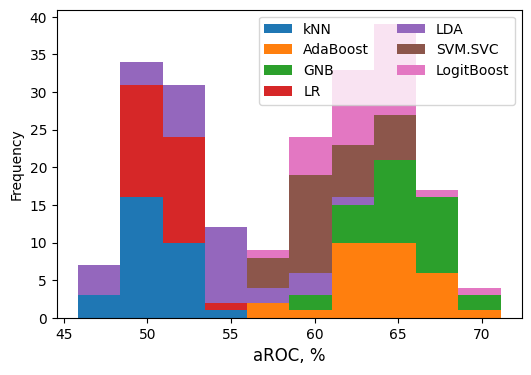

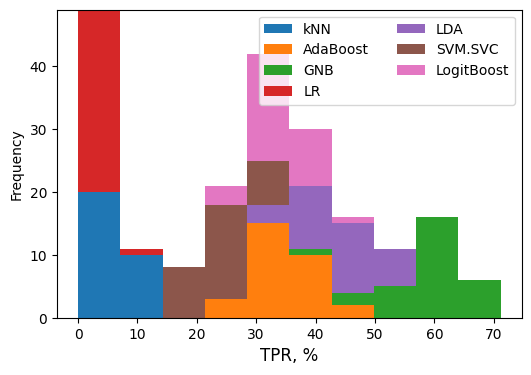

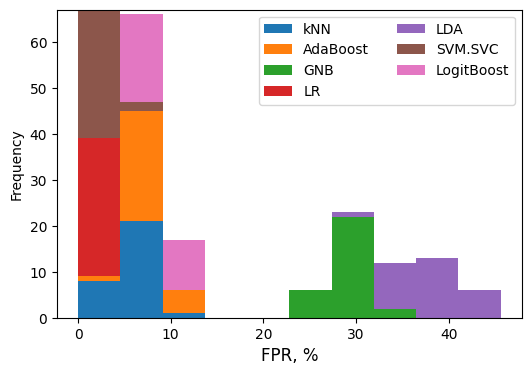

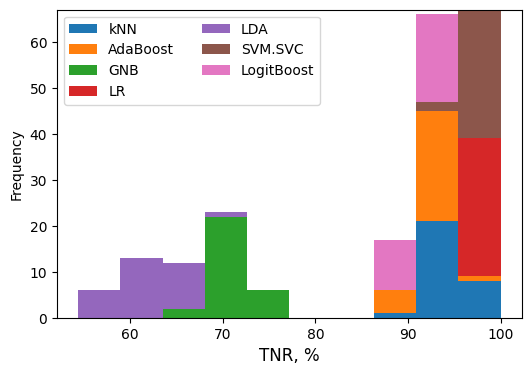

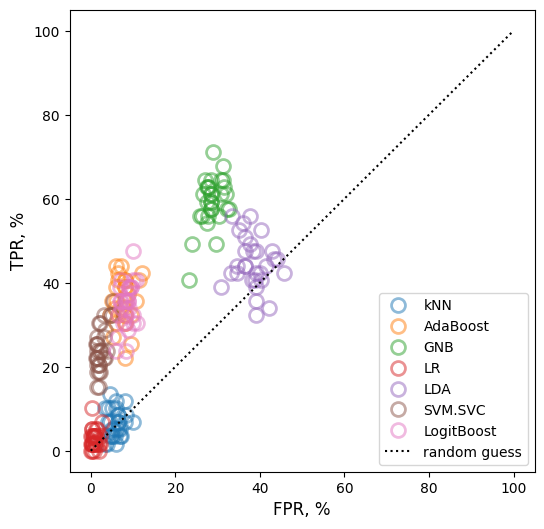

In [41]:
# my_list = list(range(100))
# convert results to percent (0-100)
_FPRs = FPRs * 100
_TPRs = TPRs * 100
_TNRs = TNRs * 100
# ERRs = ERRs * 100
_aROCs = aROCs * 100

# rv.kris - fix for data type error (was object, needs to be float)
for i in range(len(classifierNames)):
    if i not in mls_to_test:continue
    _aROCs[classifierNames[0][i]] = _aROCs[classifierNames[0][i]].astype(float)                       # rv.kris
    _TPRs[classifierNames[0][i]] = _TPRs[classifierNames[0][i]].astype(float)                       # rv.kris
    _FPRs[classifierNames[0][i]] = _FPRs[classifierNames[0][i]].astype(float)                       # rv.kris
    _TNRs[classifierNames[0][i]] = _TNRs[classifierNames[0][i]].astype(float)                       # rv.kris
    
# HISTOGRAMS
# Define parameters for histograms
bins = 10
stacked = True
figsize = (6, 4)
# Plot histograms
ax1 = _aROCs.plot.hist(stacked=stacked, bins=bins, figsize=figsize)
ax1.legend(ncol=2)
ax1.set_xlabel("aROC, %", fontsize="large")
plt.savefig("results/aROCshistmeanmaxminrel.png")

ax2 = _TPRs.plot.hist(stacked=stacked, bins=bins, figsize=figsize)
ax2.legend(ncol=2)
ax2.set_xlabel("TPR, %", fontsize="large")
plt.savefig("results/TPRshistmeanmaxminrel.png")

ax3 = _FPRs.plot.hist(stacked=stacked, bins=bins, figsize=figsize)
ax3.legend(ncol=2)
ax3.set_xlabel("FPR, %", fontsize="large")
plt.savefig("results/FPRshistmeanmaxminrel.png")

ax7 = _TNRs.plot.hist(stacked=stacked, bins=bins, figsize=figsize)
ax7.legend(ncol=2)
ax7.set_xlabel("TNR, %", fontsize="large")
plt.savefig("results/TNRshistmeanmaxminrel.png")

# SCATTER PLOT
# Define figure parameters
fig = plt.figure(figsize=(6, 6))
ax4 = fig.add_subplot(111)
marker = "o"
markersize = 10
linewidth = 0
alpha = 0.5
mfc = "None"
mew = 2
# Loop through results per algorithm
with tqdm(total=len(my_list)) as pbar:
    for cN in _FPRs.columns:
        # plot results of current algorithm
        ax4.plot(_FPRs[cN].values, _TPRs[cN].values, marker=marker, mfc=mfc, mew=mew, markersize=markersize, linewidth=linewidth, alpha=alpha, label=cN)
        # Add random guess line
    pbar.update(1)

ax4.plot([0, 100], [0, 100], "k:", label="random guess")
# Format plot
ax4.legend()
ax4.set_ylabel("TPR, %", fontsize="large")
ax4.set_xlabel("FPR, %", fontsize="large")
ax4.set_xlim(-5, 105)
ax4.set_ylim(-5, 105)
plt.savefig("results/ROCplotMLmeanmaxminrel.png")

In [42]:
# TABULAR RESULTS
aROCsum = pd.DataFrame()
aROCsum["mean"] = _aROCs.mean()
aROCsum["std"] = _aROCs.std()
aROCsum["min"] = _aROCs.min()
aROCsum["maxn"] = _aROCs.max()

TPRsum = pd.DataFrame()
TPRsum["mean"] = _TPRs.mean()
TPRsum["std"] = _TPRs.std()
TPRsum["min"] = _TPRs.min()
TPRsum["maxn"] = _TPRs.max()

FPRsum = pd.DataFrame()
FPRsum["mean"] = _FPRs.mean()
FPRsum["std"] = _FPRs.std()
FPRsum["min"] = _FPRs.min()
FPRsum["maxn"] = _FPRs.max()

TNRsum = pd.DataFrame()
TNRsum["mean"] = _TNRs.mean()
TNRsum["std"] = _TNRs.std()
TNRsum["min"] = _TNRs.min()
TNRsum["maxn"] = _TNRs.max()

print("True Negatives")
display(TNRsum)
print()
print("False Positives")
display(FPRsum)
print()
print("True Positives")
display(TPRsum)
print()
print("Receiver Operating Characteristic")
display(aROCsum)

# revert result to percent (0.0 - 1.0)
# FPRs = FPRs/100
# TPRs = TPRs/100
# aROCs = aROCs/100
# TNRs = TNRs/100

True Negatives


,mean,std,min,maxn
0,,,,
kNN,94.160,1.530,90.110,96.580
AdaBoost,92.411,1.798,87.830,95.440
GNB,71.354,2.313,67.300,76.810
LR,99.088,0.703,97.340,100.000
LDA,61.662,3.416,54.370,69.200
SVM.SVC,97.606,1.121,94.680,98.860
LogitBoost,91.519,1.286,88.970,93.920



False Positives


,mean,std,min,maxn
0,,,,
kNN,5.840,1.530,3.420,9.890
AdaBoost,7.589,1.798,4.560,12.170
GNB,28.646,2.313,23.190,32.700
LR,0.912,0.703,0.000,2.660
LDA,38.338,3.416,30.800,45.630
SVM.SVC,2.394,1.121,1.140,5.320
LogitBoost,8.481,1.286,6.080,11.030



True Positives


,mean,std,min,maxn
0,,,,
kNN,6.495,3.274,1.690,13.560
AdaBoost,35.366,5.502,22.030,44.070
GNB,59.266,5.914,40.680,71.190
LR,2.936,2.178,0.000,10.170
LDA,44.745,6.031,32.200,55.930
SVM.SVC,24.292,5.140,15.250,35.590
LogitBoost,34.632,5.242,23.730,47.460



Receiver Operating Characteristic


,mean,std,min,maxn
0,,,,
kNN,50.328,1.722,47.805,54.500
AdaBoost,63.889,2.797,57.025,68.995
GNB,65.310,2.603,58.745,71.145
LR,51.012,1.114,49.050,54.895
LDA,53.203,3.743,45.845,61.235
SVM.SVC,60.949,2.268,56.675,65.135
LogitBoost,63.076,2.470,57.680,68.785


## Comparison with traditional cumulative rainfall thresholds

In [43]:
Crain = pd.DataFrame(index=rainls.index)

cmltv = [0, 175, 42, 49, 84]
for C in cmltv:
    Crain[f"c{str(C)}"] = rainls["rain1"].shift(-C)

# addding labels to samples (rows)
Crain["den"] = rainls.den
#removing NaNs as result of cumulative and lag functions
Crain = Crain.dropna(axis=0, how="any")

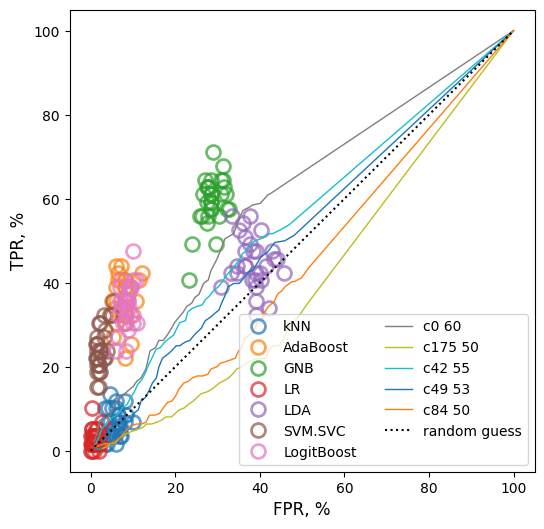

In [44]:
from scipy.stats import scoreatpercentile
# define percentiles
minpct = 1
maxpct = 99
steps = 100
rainpct = np.linspace(minpct, maxpct, steps)
# define dataframes for storing thresholds and score-at-percentiles
thresholds = pd.DataFrame(index=rainpct, columns=Crain.columns[:-1])
tprs = pd.DataFrame(index=rainpct, columns=Crain.columns[:-1])
fprs = pd.DataFrame(index=rainpct, columns=Crain.columns[:-1])
aucs = pd.DataFrame(index=rainpct, columns=Crain.columns[:-1])
# SCATTER PLOT
# define figure parameters
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# Plot results of ML algorithms
marker = "o"
markersize = 10
linewidth = 0
mfc = "None"
mew = 2
# alpha = 0.5
alpha = 0.7
# convert results to percent (0-100)
for cN in _FPRs.columns:
    # plot results of current algorithm
    ax.plot(_FPRs[cN].values, _TPRs[cN].values, marker=marker, mew=mew, mfc=mfc, markersize=markersize, linewidth=linewidth, alpha=alpha, label=cN)
    
alpha = 1
lw = 1

# Loop through cumulative rainfalls
for c in Crain.columns[:-1]:
    # compute score-at-percentiles for the current cumulative rainfall
    thresholds[c] = scoreatpercentile(Crain[c].values, thresholds.index)
    
    # loop through thresholds for the current cumulative rainfall
    for t in thresholds.index:
        # evaluate rainfall exceedence of the current threshold
        predict = np.where(Crain[c].values >= thresholds.loc[t, c], 1, 0)
        # evaluate predictive performance
        tn, fp, fn, tp = confusion_matrix(Crain["den"].values, predict).ravel()
        tpr = tp / (tp+fn)
        fpr = fp / (fp+tn)
        #store results to dataframes
        tprs.loc[t, c] = tpr
        fprs.loc[t, c] = fpr
        aucs.loc[t, c] = auc([0, fpr, 1], [0, tpr, 1])
        
    ax.plot(100 * fprs.loc[:, c], 100 * tprs.loc[:, c], lw=lw, label=f"{c} {str(int(100 * aucs.loc[:, c].max()))}", alpha=alpha)
    
#add random guess line
ax.plot([0, 100], [0, 100], "k:", label="random guess")

# format plot
ax.legend(loc="lower right", ncol=2)
ax.set_ylabel("TPR, %", fontsize="large")
ax.set_xlabel("FPR, %", fontsize="large")
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)
plt.savefig("results/ROCplotML+cmltvmeanmaxminrel.png")

In [45]:
# TABULAR RESULTS
aucsum = pd.DataFrame()
aucsum["mean"] = aucs.mean()
aucsum["std"] = aucs.std()
aucsum["min"] = aucs.min()
aucsum["maxn"] = aucs.max()

tprsum = pd.DataFrame()
tprsum["mean"] = tprs.mean()
tprsum["std"] = tprs.std()
tprsum["min"] = tprs.min()
tprsum["maxn"] = tprs.max()

fprsum = pd.DataFrame()
fprsum["mean"] = fprs.mean()
fprsum["std"] = fprs.std()
fprsum["min"] = fprs.min()
fprsum["maxn"] = fprs.max()

print("False Positives:")
print(fprsum)
print()
print("True Positives:")
print(tprsum)
print()
print("Aucsum:")
print(aucsum)

# revert results to percent (0.0 - 1.0)
fprs = fprs/100
tprs = tprs/100
aucs = aucs/100

False Positives:
      mean   std   min  maxn
c0   0.638 0.403 0.008 1.000
c175 0.648 0.382 0.011 1.000
c42  0.631 0.397 0.010 1.000
c49  0.630 0.392 0.011 1.000
c84  0.634 0.383 0.010 1.000

True Positives:
      mean   std   min  maxn
c0   0.691 0.358 0.021 1.000
c175 0.590 0.434 0.004 1.000
c42  0.666 0.366 0.013 1.000
c49  0.643 0.382 0.004 1.000
c84  0.598 0.414 0.008 1.000

Aucsum:
      mean   std   min  maxn
c0   0.527 0.035 0.500 0.606
c175 0.471 0.036 0.403 0.500
c42  0.518 0.021 0.500 0.556
c49  0.507 0.012 0.489 0.533
c84  0.482 0.020 0.439 0.500


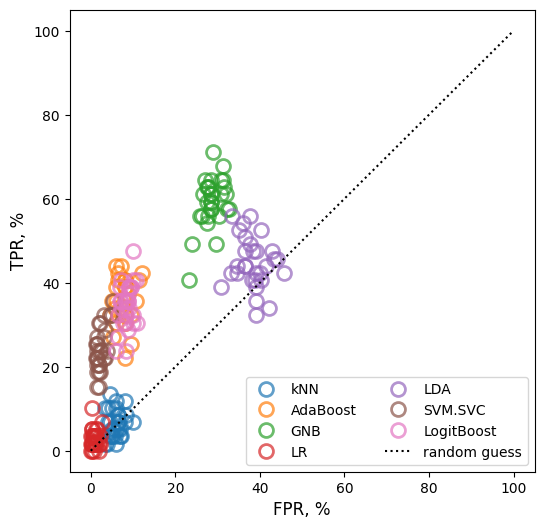

In [46]:
# define percentiles
minpct = 1
maxpct = 99
steps = 30
rainpct = np.linspace(minpct, maxpct, steps)
# define dataframes for storing thresholds and score-at percentiles
tprs = pd.DataFrame(index=rainpct,columns=Crain.columns[:-1])
fprs = pd.DataFrame(index=rainpct,columns=Crain.columns[:-1])
aucs = pd.DataFrame(index=rainpct,columns=Crain.columns[:-1])
# SCATTER PLOT
# define figure parameters
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# Plot results of ML algorithms
marker = "o"
markersize = 10
linewidth = 0
mfc = "None"
mew = 2
alpha = 0.7

for cN in _FPRs.columns:
    ax.plot(_FPRs[cN].values, _TPRs[cN].values, marker=marker, mew=mew, mfc=mfc, markersize=markersize, linewidth=linewidth, alpha=alpha, label=cN)

alpha = 1
lw = 1

# add random guess line
ax.plot([0, 100], [0, 100], "k:", label="random guess")

# format plot
ax.legend(loc="lower right", ncol=2)
ax.set_ylabel("TPR, %", fontsize="large")
ax.set_xlabel("FPR, %", fontsize="large")
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)
plt.savefig("results/ROCplotML.png")